<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

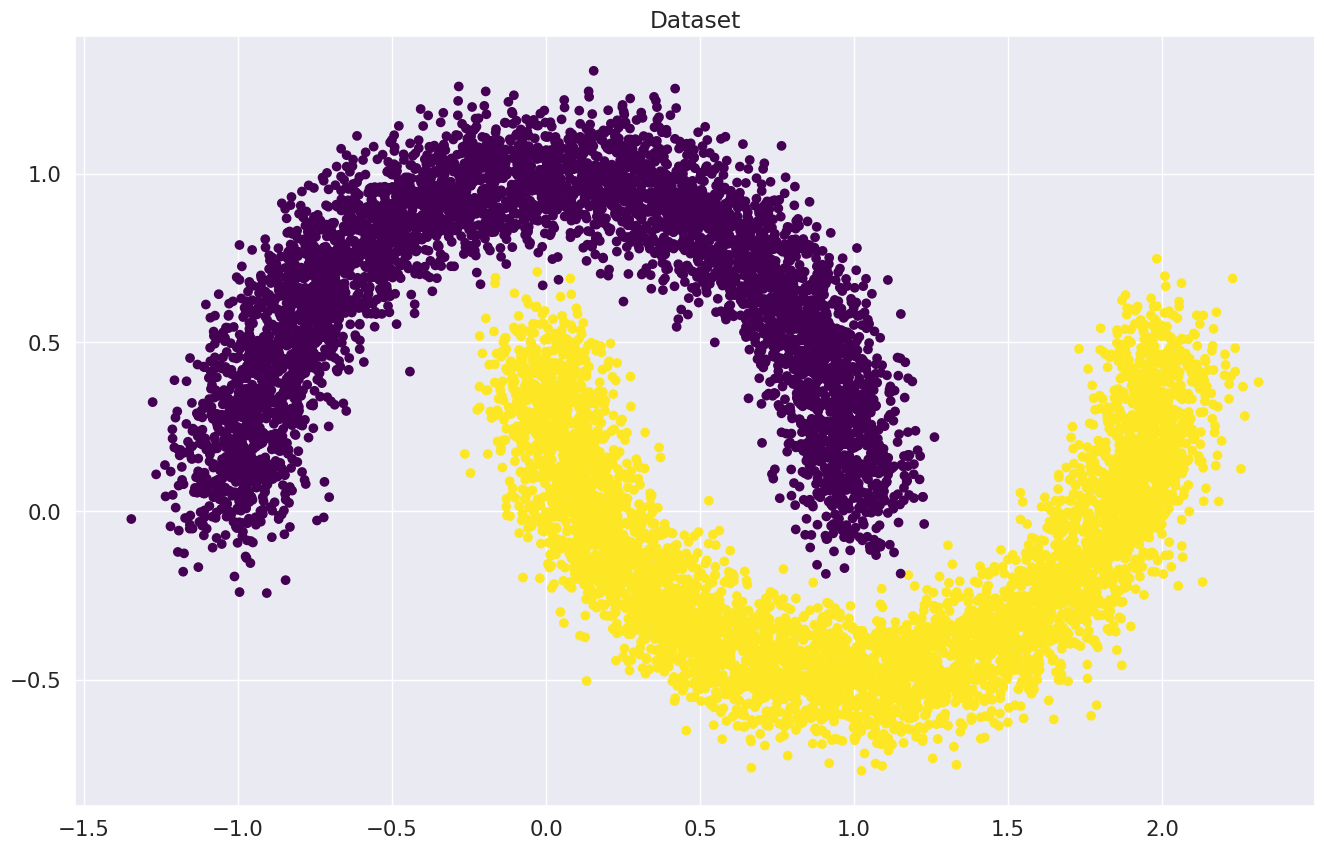

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

In [6]:
print(X_train_t.shape, X_val_t.shape)

torch.Size([7500, 2]) torch.Size([2500, 2])


Создаем `Dataset` и `DataLoader`.

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [8]:
x_batch, y_batch = next(iter(train_dataloader))
print(x_batch.shape, y_batch.shape)

torch.Size([128, 2]) torch.Size([128])


## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features),
                                    requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features),
                                          requires_grad=True)

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

***Ответ:*** три параметра - два в матрице весов $W$ и один в свободном члене $b$.

In [11]:
!pip install torchinfo

In [12]:
from torchinfo import summary

summary(linear_regression, (1, 2), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

***Ответ:*** итого 3 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp, y_batch[:, None])
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.special.expit(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4921875
Iteration: 100
Batch accuracy: 0.765625
Iteration: 200
Batch accuracy: 0.78125
Iteration: 300
Batch accuracy: 0.859375
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8046875
Iteration: 800
Batch accuracy: 0.828125

Iteration: 818.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** у меня алгоритм сошелся за 818 итераций

### Визуализируем результаты

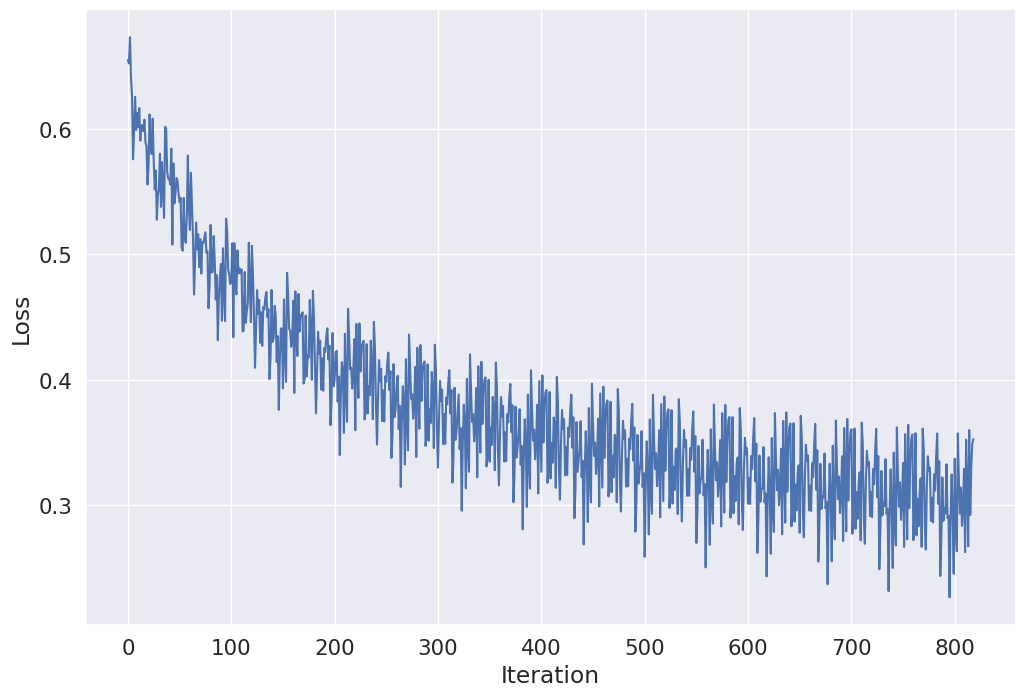

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

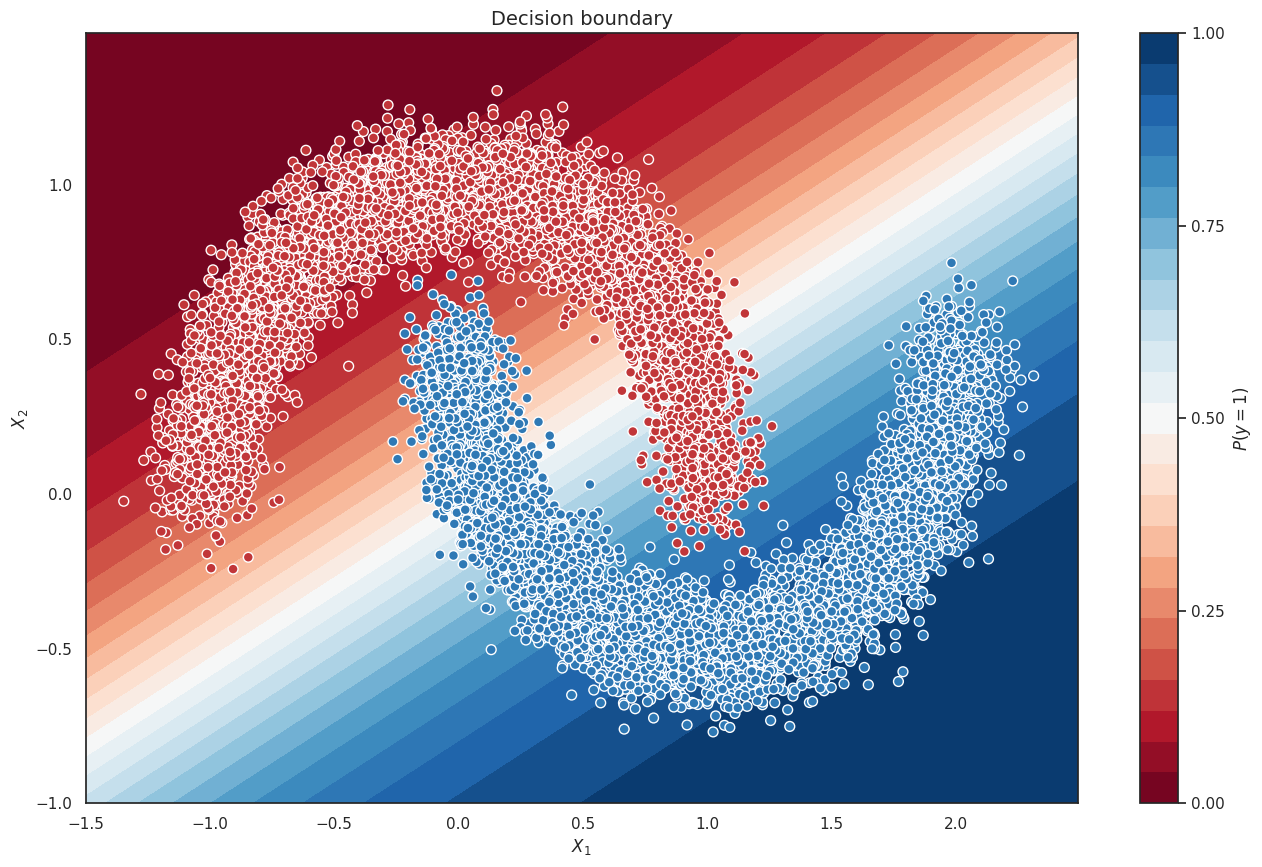

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = torch.special.expit(model(x_batch))
        preds = (outp > 0.5).type(torch.int)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

print('Accuracy score of test prediction is', accuracy_score(predict(val_dataloader, linear_regression), y_val_t))

Accuracy score of test prediction is 0.8584


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8576

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(train_dataset[0][0].shape[1]**2, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                      outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            torch.cuda.empty_cache()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8931166666666667
Loader: valid. Accuracy: 0.9309
Epoch: 2
Loader: train. Accuracy: 0.9514
Loader: valid. Accuracy: 0.9642
Epoch: 3
Loader: train. Accuracy: 0.9656666666666667
Loader: valid. Accuracy: 0.9664
Epoch: 4
Loader: train. Accuracy: 0.9725
Loader: valid. Accuracy: 0.9648
Epoch: 5
Loader: train. Accuracy: 0.9765833333333334
Loader: valid. Accuracy: 0.9722
Epoch: 6
Loader: train. Accuracy: 0.9798833333333333
Loader: valid. Accuracy: 0.9738
Epoch: 7
Loader: train. Accuracy: 0.98145
Loader: valid. Accuracy: 0.9712
Epoch: 8
Loader: train. Accuracy: 0.9838666666666667
Loader: valid. Accuracy: 0.9762
Epoch: 9
Loader: train. Accuracy: 0.9851666666666666
Loader: valid. Accuracy: 0.9707
Epoch: 10
Loader: train. Accuracy: 0.9873333333333333
Loader: valid. Accuracy: 0.9777


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
activation_grid = {'no activation': Identical,
                   'ELU': nn.ELU,
                   'ReLU': nn.ReLU,
                   'LeakyReLU': nn.LeakyReLU}

In [30]:
# Filling 'accuracies: dict' with values of different accuracies
def test_activation_function(activations: dict):
    accuracies = {}
    for label, activation in activations.items():
        print('**********')
        print(f'Activation function: {label}')
        print('**********')
        model = nn.Sequential(nn.Flatten(),
                              nn.Linear(train_dataset[0][0].shape[1]**2, 128),
                              activation(),
                              nn.Linear(128, 128),
                              activation(),
                              nn.Linear(128, 10))

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        valid_accuracy_list = one_model_train(model, criterion, optimizer)
        accuracies.setdefault(label, valid_accuracy_list)
    print('**********')
    return accuracies

In [31]:
# Training one kind of model
def one_model_train(model, criterion, optimizer):
    accuracy_list = []
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            ac = train_loop(model, epoch, k, dataloader, criterion, optimizer)
            if ac:
                accuracy_list.append(ac)
    return accuracy_list

In [32]:
# Optimizing on one epoch
def train_loop(model, epoch, k, dataloader, criterion, optimizer):
    epoch_correct, epoch_all = 0, 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if k == "train":
            model.train()
            optimizer.zero_grad()
            outp = model(x_batch)
        else:
            model.eval()
            with torch.no_grad():
                outp = torch.softmax(model(x_batch), dim=1)
        preds = outp.argmax(-1)
        correct = (preds == y_batch).sum()
        all =  len(preds)
        epoch_correct += correct.item()
        epoch_all += all
        if k == "train":
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()
        torch.cuda.empty_cache()
    if k == "train":
        print(f"Epoch: {epoch+1}")
    print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
    if k == 'valid':
        return epoch_correct/epoch_all

In [33]:
# Computing according to the grid (~13 min)
accuracies = test_activation_function(activation_grid)

**********
Activation function: no activation
**********
Epoch: 1
Loader: train. Accuracy: 0.8744833333333333
Loader: valid. Accuracy: 0.9035
Epoch: 2
Loader: train. Accuracy: 0.90055
Loader: valid. Accuracy: 0.8954
Epoch: 3
Loader: train. Accuracy: 0.9057166666666666
Loader: valid. Accuracy: 0.9107
Epoch: 4
Loader: train. Accuracy: 0.9091833333333333
Loader: valid. Accuracy: 0.9021
Epoch: 5
Loader: train. Accuracy: 0.9100666666666667
Loader: valid. Accuracy: 0.9137
Epoch: 6
Loader: train. Accuracy: 0.9113333333333333
Loader: valid. Accuracy: 0.9067
Epoch: 7
Loader: train. Accuracy: 0.9129
Loader: valid. Accuracy: 0.9152
Epoch: 8
Loader: train. Accuracy: 0.9139166666666667
Loader: valid. Accuracy: 0.8942
Epoch: 9
Loader: train. Accuracy: 0.9145666666666666
Loader: valid. Accuracy: 0.9134
Epoch: 10
Loader: train. Accuracy: 0.9152833333333333
Loader: valid. Accuracy: 0.9135
**********
Activation function: ELU
**********
Epoch: 1
Loader: train. Accuracy: 0.8946
Loader: valid. Accuracy: 0.

In [35]:
# I reached these values
accuracies = {'no activation': [0.9035, 0.8954, 0.9107, 0.9021, 0.9137, 0.9067, 0.9152, 0.8942, 0.9134, 0.9135],
              'ELU': [0.9438, 0.9618, 0.9654, 0.9704, 0.9743, 0.9747, 0.9762, 0.9757, 0.9772, 0.9779],
              'ReLU': [0.931, 0.9574, 0.9617, 0.9603, 0.9686, 0.9632, 0.9714, 0.9648, 0.9736, 0.9735],
              'LeakyReLU': [0.9403, 0.9582, 0.9652, 0.9674, 0.9665, 0.9703, 0.9718, 0.9717, 0.9681, 0.9729]}

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

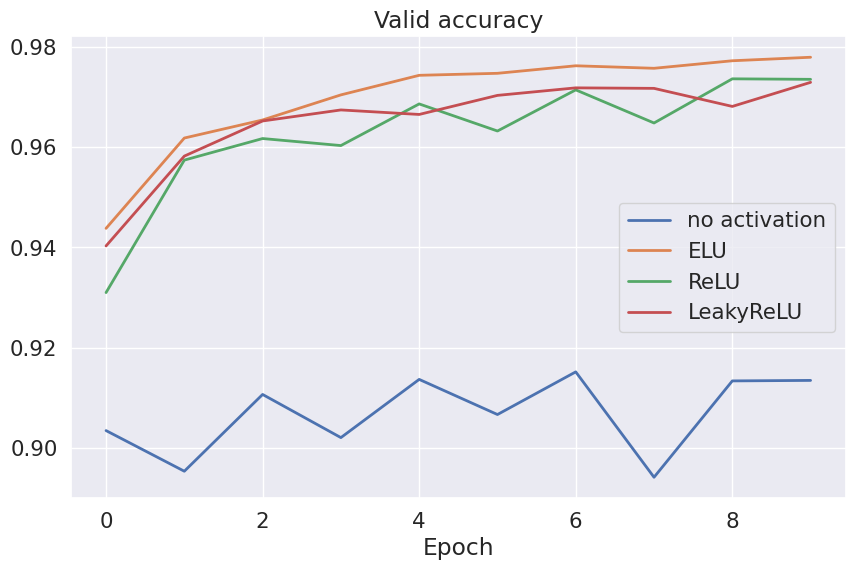

In [39]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(10, 6))
plt.title("Valid accuracy")
for accuracy_label, accuracy_list in accuracies.items():
    plt.plot(range(max_epochs), accuracy_list, label=accuracy_label, linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

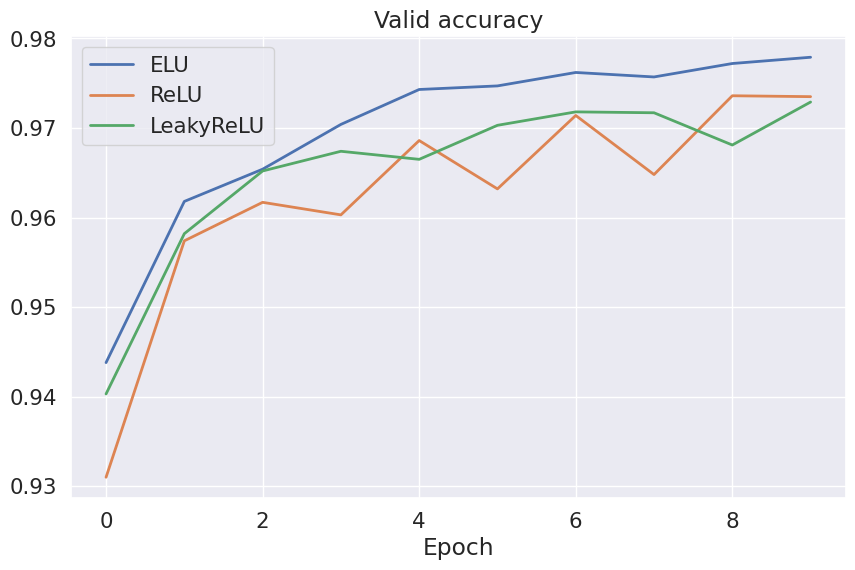

In [40]:
max_value = 0
plt.figure(figsize=(10, 6))
plt.title("Valid accuracy")
for accuracy_label, accuracy_list in accuracies.items():
    if accuracy_label != 'no activation':
        plt.plot(range(max_epochs), accuracy_list, label=accuracy_label, linewidth=2)
    best = max(accuracy_list)
    if best > max_value:
        max_label = accuracy_label
        max_value = best
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [41]:
print(f'Наивысшее значение показала функция активации {max_label}: accuracy =', max_value)

Наивысшее значение показала функция активации ELU: accuracy = 0.9779


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** `ELU`

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [45]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-29 13:30:11--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   236KB/s    in 0.2s    

2023-10-29 13:30:11 (236 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



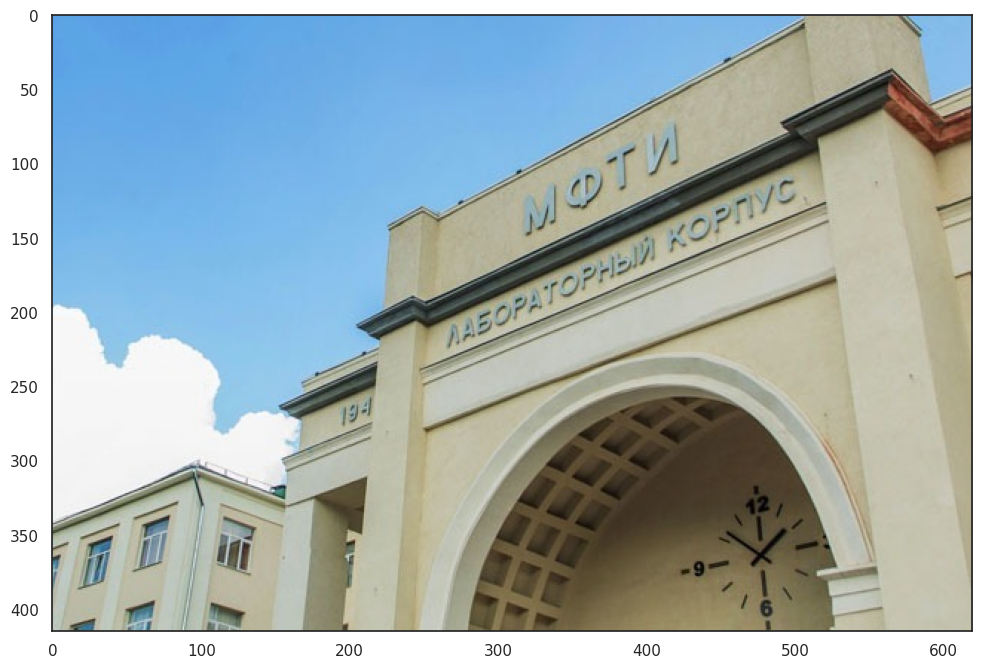

In [46]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

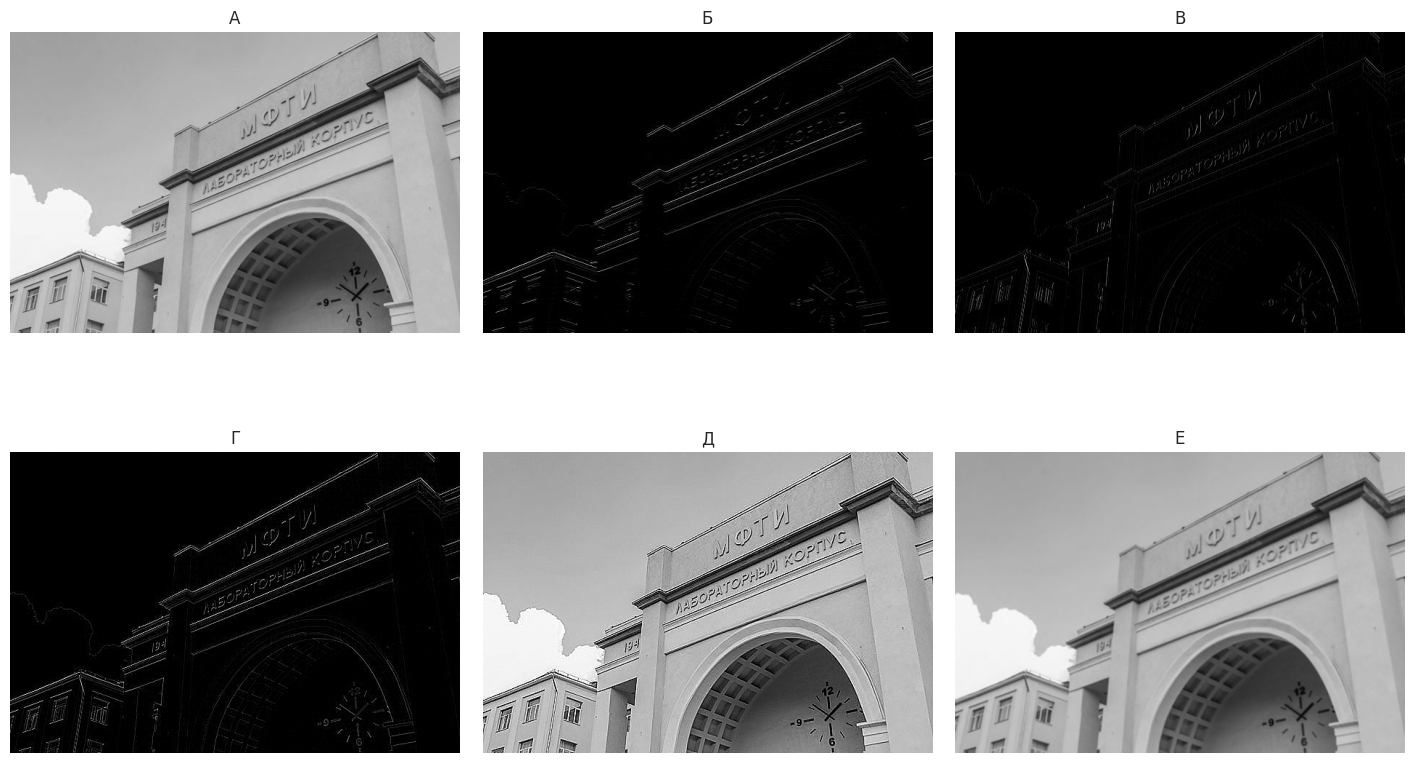

In [47]:
def transform_to_filter(list_of_lists):
    filter4d = torch.tensor(list_of_lists).reshape(1, 1, 3, 3).type(torch.float32)
    return filter4d.repeat(3, 3, 1, 1)

filters = {
    'А': transform_to_filter([[0, 0, 0],
                              [0, 1, 0],
                              [0, 0, 0]]),
    'Б': transform_to_filter([[0, 1, 0],
                              [0, -2, 0],
                              [0, 1, 0]]),
    'В': transform_to_filter([[0, 0, 0],
                              [1, -2, 1],
                              [0, 0, 0]]),
    'Г': transform_to_filter([[0, 1, 0],
                              [1, -4, 1],
                              [0, 1, 0]]),
    'Д': transform_to_filter([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]]),
    'Е': transform_to_filter([[0.0625, 0.125, 0.0625],
                              [0.125, 0.25, 0.125],
                              [0.0625, 0.125, 0.0625]])
}

img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(wspace=0.05)
for i, label in enumerate(filters.keys()):
    n, k = i // 3, i % 3
    result = F.conv2d(img_t, filters[label])[0]
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    axes[n][k].set_title(label)
    axes[n][k].imshow(result_np)
    axes[n][k].axis('off')

fig.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А - 3, Б - 5, В - 4, Г - 6, Д - 2, Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [48]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [49]:
summary(model, (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 128]                100,480
├─ELU: 1-3                               [100, 128]                --
├─Linear: 1-4                            [100, 128]                16,512
├─ELU: 1-5                               [100, 128]                --
├─Linear: 1-6                            [100, 10]                 1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 11.83
Input size (MB): 0.31
Forward/backward pass size (MB): 0.21
Params size (MB): 0.47
Estimated Total Size (MB): 1.00

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [51]:
# Training LeNet (~ 5 min)
lenet_accuracy = one_model_train(model, criterion, optimizer)

Epoch: 1
Loader: train. Accuracy: 0.8868833333333334
Loader: valid. Accuracy: 0.9696
Epoch: 2
Loader: train. Accuracy: 0.9727
Loader: valid. Accuracy: 0.979
Epoch: 3
Loader: train. Accuracy: 0.9810333333333333
Loader: valid. Accuracy: 0.9807
Epoch: 4
Loader: train. Accuracy: 0.9854166666666667
Loader: valid. Accuracy: 0.9865
Epoch: 5
Loader: train. Accuracy: 0.9873333333333333
Loader: valid. Accuracy: 0.9847
Epoch: 6
Loader: train. Accuracy: 0.9890333333333333
Loader: valid. Accuracy: 0.9881
Epoch: 7
Loader: train. Accuracy: 0.9906833333333334
Loader: valid. Accuracy: 0.9851
Epoch: 8
Loader: train. Accuracy: 0.9916666666666667
Loader: valid. Accuracy: 0.9872
Epoch: 9
Loader: train. Accuracy: 0.9932166666666666
Loader: valid. Accuracy: 0.9869
Epoch: 10
Loader: train. Accuracy: 0.9934
Loader: valid. Accuracy: 0.989


Сравним с предыдущем пунктом

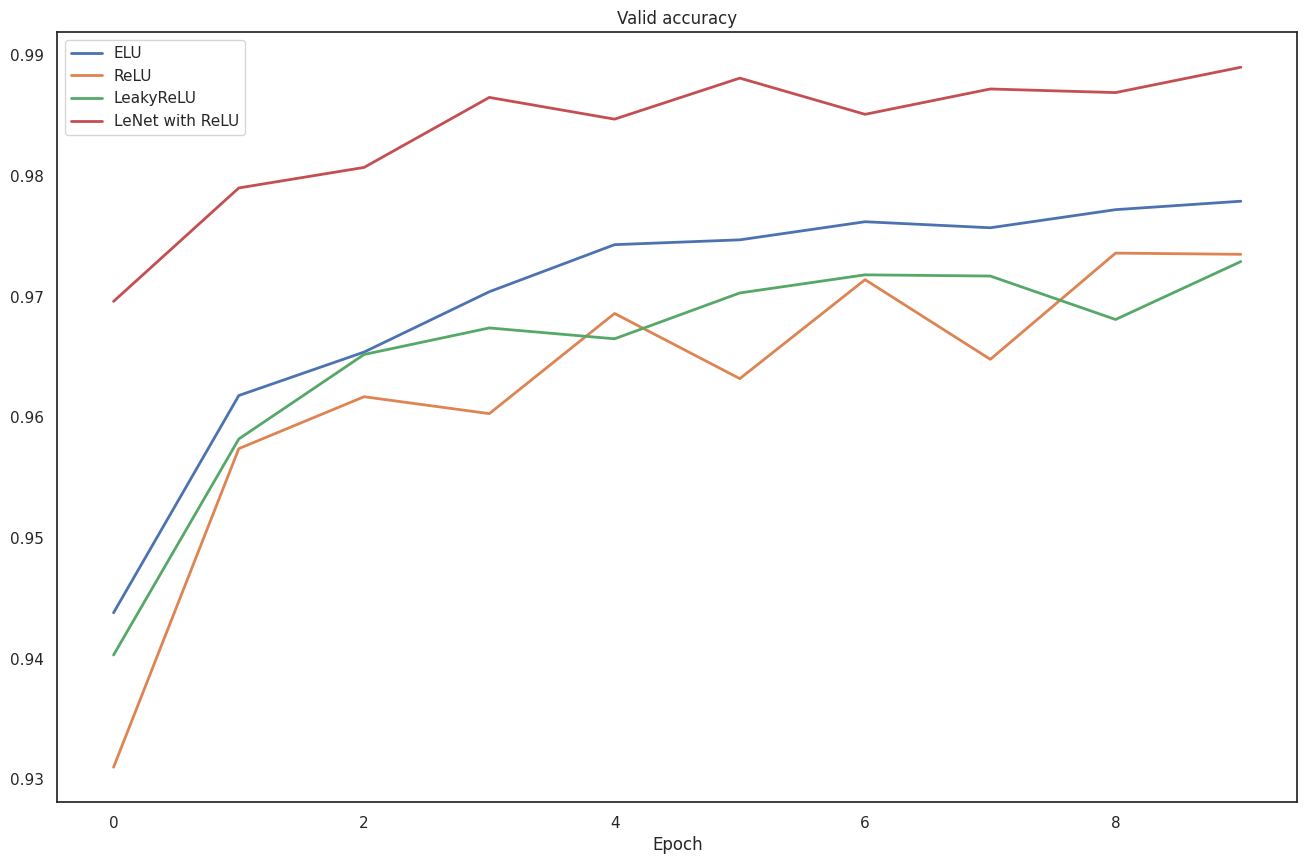

In [52]:
max_value = 0
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
for accuracy_label, accuracy_list in accuracies.items():
    if accuracy_label != 'no activation':
        plt.plot(range(max_epochs), accuracy_list, label=accuracy_label, linewidth=2)
    best = max(accuracy_list)
    if best > max_value:
        max_label = accuracy_label
        max_value = best
plt.plot(range(max_epochs), lenet_accuracy, label='LeNet with ReLU', linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [55]:
lenet_accuracy = [0.9696, 0.979, 0.9807, 0.9865, 0.9847, 0.9881, 0.9851, 0.9872, 0.9869, 0.989]
print(lenet_accuracy[-1])

0.989


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99, что выше чем у всех предыдущих моделей